# HUBO(Higher Order Unconstraint Binary Optimization)

Let us consider a model that introduces a higher-order term compared to the usual Ising model. Specifically, we introduce the following energy function for the binary variables $\sigma_{i} \in \{-1, +1\}$ or $\sigma_{i} \in \{0, 1\}$:

$$
H= c+\sum_{i} h_{i} \sigma_{i}+\sum_{i<j} J_{i j} \sigma_{i} \sigma_{j}+\sum_{i<j<k} K_{i, j, k} \sigma_{i} \sigma_{j} \sigma_{k}+\cdots,
\\
i=1,\ldots, N
$$

where the subscript $i,j,k,\ldots$ are indexes that specify binary variables and take the value of $1\leq i,j,k,\dots \leq N$. The $c$ is a constant and corresponds to a zero-order term.
The problem of finding the pair of variables $(\sigma_{1}, \sigma_{2}, \ldots, \sigma_{N})$ that gives the minimum value of this energy function is called higher-order unconstrained binary optimization (HUBO) or polynomial unconstrained binary optimization (PUBO). In the following, HUBO will be used as the unified term.
This type of problem can be regarded as a natural extension of the usual Ising model and appears in fields such as quantum chemistry.
We will show how to solve HUBO using OpenJij in this tutorial.

In OpenJij, problems can be computed directly using HUBO, but the method of converting HUBO to QUBO before the computation is also often used.
At the end of this tutorial, we will investigate how much the results differ between direct and indirect solution methods for HUBO.

## Definition of HUBO

In this tutorial, for simplicity, we will consider the problem of $N=3$ variables in which only terms of third-order or lower appear as follows. In the following, variables are assumed to be spin variables of $\sigma_i \in \{-1,+1\}$.

$$
H = -\sigma_1 -\sigma_1\sigma_2 +\sigma_1\sigma_2\sigma_3,\;\;\; \sigma_i \in \{-1, +1\}
$$

To solve this problem in OpenJij, we first represent this energy function interaction $h_i, J_{ij}, K_{ijk}$ in python dictionary type.
As interaction coefficients are specified for the Ising model, we set the key of the dictionary-type to the index specifying the spin variable involved in the interaction, and the value to the value of the corresponding interaction.

In [1]:
polynomial = {(1,): -1, (1,2): -1, (1,2,3): 1}

## Direct HUBO solving

Normally, when solving HUBO, QUBO is generated by reducing the order of the interaction to second-order or lower and then solving it.
OpenJij can solve HUBO directly using the simulated annealing without converting HUBO to QUBO by using the following sample_hubo method.

In [2]:
!pip install openjij

In [3]:
import openjij as oj

# The SASampler method must be selected to use the sample_hubo method.
sampler = oj.SASampler()

# Select sample_hubo method.
# The second argument of the sample_hubo method is the type of variable. 
# "SPIN" or "BINARY" are the options.
# SPIN specifies {-1,1} and BINARY specifies {0,1}.  
response = sampler.sample_hubo(polynomial, "SPIN")
# Check the result.
print(response)

   1  2  3 energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


$\sigma_1=+1,\;\sigma_2=+1,\;\sigma_3=-1$ is obtained as the solution.
The energy in this case is -3, which is the optimal solution.

Note that the sample_hubo method can handle non-numeric values as dictionary keys, as shown below.

In [4]:
response = sampler.sample_hubo({('a',): -1, ('a', 'b'): -1, ('a', 'b', 'c'): 1}, "SPIN")
print(response)

   a  b  c energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


For example, ('a', 'b'): -1 means that the magnitude of the interaction coefficient between spin a and spin b is -1.

## Indirect HUBO solving: solving by QUBO transformation

One way to solve HUBO is to convert terms of a higher order than the third order to the second-order or lower, construct the corresponding QUBO, and solve it.
This section explains such a method.

To generate the corresponding QUBO from the third-order interaction, we use D-Wave's dimod library.
Here, the penalty strength set to 5.0 is the penalty for the constraint conditions that arise when converting higher-order interactions to second-order or lower-order interactions. When it is too small, the optimal solution for the generated QUBO will not match the original HUBO, but when it is too large on the other hand, the optimal solution will not be obtained in the first place. In practice, it is difficult to determine how much value to specify, but here we set the value to 5.0.

In [5]:
import dimod

# Generate the corresponding quadratic model by specifying HUBO, the size of strength, and the type of variable.
bqm_dimod = dimod.make_quadratic(poly=polynomial, strength=5.0, vartype="SPIN")
print('zeroth-order term:', bqm_dimod.offset)
print('first-order term:', dict(bqm_dimod.linear))    # bqm.linear converts to python dict
print('quadratic-order term:', dict(bqm_dimod.quadratic)) # bqm.quadratic converts to python dict as well

zeroth-order term: 10.0
first-order term: {1: -3.5, 3: -2.5, '1*3': -2.5, 'aux1,3': -5.0, 2: 0.0}
quadratic-order term: {(3, 1): 2.5, ('1*3', 1): 2.5, ('1*3', 3): 2.5, ('aux1,3', 1): 5.0, ('aux1,3', 3): 5.0, ('aux1,3', '1*3'): 5.0, (2, 1): -1.0, (2, '1*3'): 1.0}


As shown, in addition to the original variables $\sigma_1,\sigma_2,\sigma_3$, two string variables $\sigma_{"1∗2"}$ and $\sigma_{"\rm aux1,2"}$ appear. In general, converting HUBO to QUBO increases the number of variables and interactions.
In this case, the HUBO had 3 variables and 3 interactions, but by converting to the QUBO, the number of variables and interactions increases to 5 and 7, respectively.

We want to solve this QUBO with OpenJij's SA, but since OpenJij cannot handle variables that are a mixture of numbers and strings, we need to convert all strings to integers.
To do so, we use dimod's method label_variables to convert "1∗2" and "aux1,2" to integers.

In [6]:
#Define a function to create a mapping between strings and integers.
def generate_mapping(variables, N):
    mapping = {}
    #Do not change the index of N, which is originally an integer.
    for i in range(1, N+1):
        mapping[i] = i 
    count = N+1
    
    #Convert newly appearing strings to integers.
    for v in variables:
        if type(v) == str:
            mapping[v] = count
            count += 1
    return mapping

# Create a dictionary that represents the correspondence between variables before and after conversion.
mapping = generate_mapping(bqm_dimod.variables, 3)

# Convert the index to an integer starting with 1.
bqm_dimod.relabel_variables(mapping)

print('zeroth-order term:', bqm_dimod.offset)
print('first-order term:', dict(bqm_dimod.linear))    # bqm.linear converts to python dict
print('quadratic-order term:', dict(bqm_dimod.quadratic)) # bqm.quadratic converts to python dict as well
print('Variable correspondence:', mapping) # prints the correspondence between the index after relabeling and the original index.

zeroth-order term: 10.0
first-order term: {1: -3.5, 3: -2.5, 4: -2.5, 5: -5.0, 2: 0.0}
quadratic-order term: {(3, 1): 2.5, (4, 1): 2.5, (4, 3): 2.5, (5, 1): 5.0, (5, 3): 5.0, (5, 4): 5.0, (2, 1): -1.0, (2, 4): 1.0}
Variable correspondence: {1: 1, 2: 2, 3: 3, '1*3': 4, 'aux1,3': 5}


All indices have been converted to integers, and we can solve this QUBO using OpenJij.

In [7]:
# Convert dimod bqm to OpenJij BinaryQuadraticModel.
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_dimod.linear), dict(bqm_dimod.quadratic), bqm_dimod.offset, vartype="SPIN")

# Use the sample method to perform SA.
response = sampler.sample(bqm_oj)
print(response) 

   1  2  3  4  5 energy num_oc.
0 +1 +1 -1 -1 +1   -3.0       1
['SPIN', 1 rows, 1 samples, 5 variables]


The energy obtained here may not correspond to the original energy of HUBO, depending on the value of strength determined earlier.
Therefore, it is necessary to calculate the energy again.
In this case, the original variables were $\sigma_1,\sigma_2,\sigma_3$, so we will calculate the energy using only these spin configurations.
Here we note as $\sigma_1=+1,\sigma_2=+1,$ and $\sigma_3=-1$.

In [8]:
# Bake back to the original HUBO solution.
hubo_configuration = {i+1: response.record[0][0][i] for i in range(3)}
print('Corresponding HUBO solution:', hubo_configuration)
print('Energy of the corresponding HUBO solution:', dimod.BinaryPolynomial(polynomial, "SPIN").energy(hubo_configuration))

Corresponding HUBO solution: {1: 1, 2: 1, 3: -1}
Energy of the corresponding HUBO solution: -3.0


Here we have obtained a spin configuration that gives -3 as the energy. This is the optimal solution for this energy function.

This can be verified with dimod's ExactPolySolver, which is a solver for exact optimal solutions.

In [9]:
# Check the exact optimal solution of the original HUBO.
sampleset = dimod.ExactPolySolver().sample_hising(h = {}, J = polynomial)
print('Optimal solution:',sampleset.first.sample)
print('Corresponding energy:',sampleset.first.energy)

Optimal solution: {1: 1, 2: 1, 3: -1}
Corresponding energy: -3.0


The energy of the optimal solution for the original HUBO is indeed -3.0.
Note that the exact solution can be easily obtained in this case because the number of variables was only 3, but it is usually difficult to obtain an exact solution.

## Comparing the results of direct HUBO solving and indirect HUBO solving

Finally, let us compare the direct HUBO solution with the indirect HUBO solution where QUBO transformation is used. We run 100 simulations with SA and compare the energies obtained in each simulation.

First, we obtain the energy when using the sample_HUBO method.

In [10]:
# Specify the number of simulation times with SA.
num_reads = 100

# SA will be performed independently for num_reads number of times.
# Here, we set it to 100. The default is 1.
response = sampler.sample_hubo(polynomial, "SPIN", num_reads=num_reads)

# Assign the obtained energy to energy_hubo.
energy_hubo = response.energies

Next, we find the energy by solving using the QUBO transformation.
Note that the energy of HUBO must be recalculated each time because there is no guarantee that the magnitude of the previously set strength is appropriate.

In [11]:
response = sampler.sample(bqm_oj, num_reads=num_reads)

# Define a function to recalculate the energy of HUBO from the obtained spin configuration.
def calculate_true_energy(polynomial, response, N):
    energy_quad = []
    for i in range(num_reads):
        hubo_configuration = {j+1: response.record[i][0][j] for j in range(N)}
        energy_quad.append(dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration))
    return energy_quad

# Substitute the obtained energy into energy_quad.
energy_quad = calculate_true_energy(polynomial, response, 3)

The obtained 100 results are compared in a histogram.

Text(0, 0.5, 'Frequency')

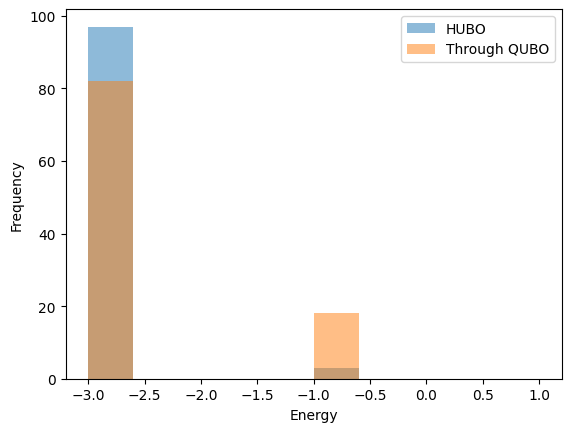

In [12]:
import matplotlib.pyplot as plt
plt.hist(energy_hubo, label='HUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.hist(energy_quad, label='Through QUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

The direct HUBO solution yields slightly more optimal solutions than solving with QUBO transformation.
However, in this problem, if strength is set to 1 for example, the solution with QUBO transformation yields more optimal solutions.
In other words, the initial value of strength set to 5 is too large as we check below.

Text(0.5, 0, 'Energy')

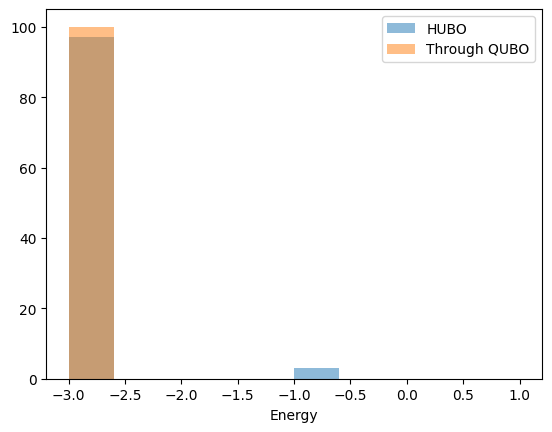

In [13]:
# Convert to QUBO with strength set to 1.
bqm_dimod = dimod.make_quadratic(poly=polynomial, strength=1.0, vartype="SPIN")

#Convert the indices to integers and then solve with OpenJij.
bqm_dimod.relabel_variables(mapping)
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_dimod.linear), dict(bqm_dimod.quadratic), bqm_dimod.offset,
vartype="SPIN")
response = sampler.sample(bqm_oj, num_reads=num_reads)

energy_quad = calculate_true_energy(polynomial, response, 3)
# Display the histogram.
plt.hist(energy_hubo, label='HUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.hist(energy_quad, label='Through QUBO', range=(-3, 1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')

In the current case, the solution by QUBO transformation always provides the optimal solution.
Note that the optimal strength value is not known in advance.
In this case, the optimal solution is obtained with strength as 1, but determining the appropriate strength for general HUBO is a difficult problem.
Another problem is that the QUBO transformation increases the number of variables and interactions. This requires extra memory.

The model we have treated so far as an example is too simple, so let us compare the two solutions with a larger problem.
Let us set the number of variables to $N=10$, the interactions to third-order all couplings, and the values to random from -1 to +1.

First, we define the interaction.

In [14]:
import random

N=10
polynomial = {}
for i in range(1, N+1):
    for j in range(i+1, N+1):
        for k in range(j+1, N+1):
            polynomial[(i,j,k)] = random.uniform(-1, +1)

As before, we will perform 100 SAs and compare the energies obtained. The strength for the QUBO conversion is set to 2.

Text(0, 0.5, 'Frequency')

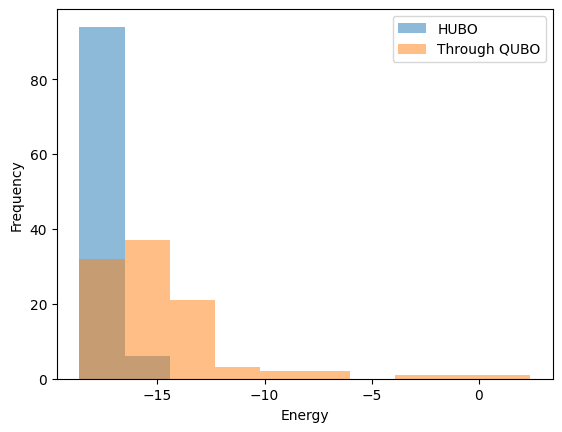

In [15]:
# Solve directly with the HUBO solver.
response = sampler.sample_hubo(polynomial, "SPIN", num_reads=num_reads)
energy_hubo = response.energies

# Solve through the QUBO transform.
bqm_dimod = dimod.make_quadratic(poly=polynomial, strength=2, vartype="SPIN")
mapping = generate_mapping(bqm_dimod.variables, N)
bqm_dimod.relabel_variables(mapping)
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_dimod.linear), dict(bqm_dimod.quadratic), bqm_dimod.offset, vartype="SPIN")
response = sampler.sample(bqm_oj, num_reads=num_reads)
energy_quad = calculate_true_energy(polynomial, response, N)

# Display the histogram.
max_e = max(max(energy_hubo), max(energy_quad))
min_e = min(min(energy_hubo), min(energy_quad))
plt.hist(energy_hubo, label='HUBO', range=(min_e, max_e), alpha=0.5)
plt.hist(energy_quad, label='Through QUBO', range=(min_e, max_e), alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

We can see that there is quite a difference in this model: solving directly for HUBO yields a lower energy solution.
Of course, a more appropriate value of strength could improve the solution by solving for the QUBO transformation, but that is not easy to do.

## Summary

The solution method using the QUBO transformation requires preprocessing to convert to QUBO and to determine a parameter called strength.
On the other hand, the HUBO solver eliminates the need for such processing, and (at least for the models treated in this study) the solutions obtained are as good as or better than those obtained by the QUBO solver.